In [1]:
#!pip install plot_confusion_matrix


In [2]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


# Sklearn for confusion matrix
from sklearn.utils.class_weight import compute_class_weight

import itertools
# For visualization of plots without plt.show()
%matplotlib inline


In [3]:
dataset_url =r'C:\Users\abudh\Desktop\CropWatch\EuroSAT\2750'
batch_size = 50
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255
no_epochs = 50



In [4]:

# 3. Data Augmentation and Loading
datagen = ImageDataGenerator(
    rescale=rescale,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='nearest',
    validation_split=validation_split
)

dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [5]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [6]:

test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())
class_indices = list(class_indices.values())

class_counts_dict = {class_name: len(glob.glob(os.path.join(dataset_url, class_name, '*'))) for class_name in class_labels}
class_counts = np.array([class_counts_dict[class_name] for class_name in class_labels])

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_indices),
    y=np.array([train_dataset.classes[i] for i in range(len(train_dataset.classes))])
)

class_weight_dict = dict(zip(class_labels, weights))
print("Class weights:")
for label, weight in class_weight_dict.items():
    print(f"Class '{label}': {weight:.4f}")

Class weights:
Class 'AnnualCrop': 0.9000
Class 'Forest': 0.9000
Class 'HerbaceousVegetation': 0.9000
Class 'Highway': 1.0800
Class 'Industrial': 1.0800
Class 'Pasture': 1.3500
Class 'PermanentCrop': 1.0800
Class 'Residential': 0.9000
Class 'River': 1.0800
Class 'SeaLake': 0.9000


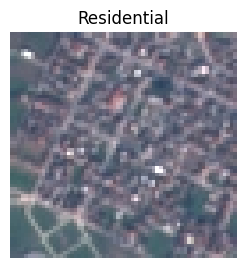

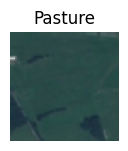

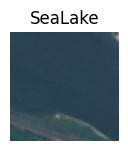

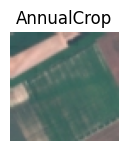

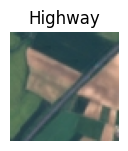

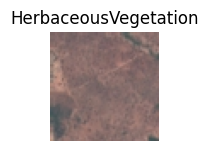

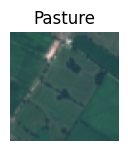

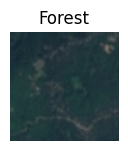

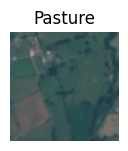

In [8]:

class_names = dataset.class_names
no_class= (len(class_names))
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show()

In [9]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [10]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [11]:
def ResNet50(input_shape = (64, 64, 3), classes = len(class_names)):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [12]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=1,
    restore_best_weights=True
)


model = ResNet50(input_shape=(img_height, img_width, 3), classes=len(class_names))


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path where the weights will be saved
model_path = r'C:\Users\abudh\Desktop\CropWatch'

# Define the checkpoint callback to save weights every 5 epochs with a dynamic name
dynamic_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\Training_model_epoch{epoch:02d}.weights.h5',  # Use .weights.h5 extension
    save_freq=5,  # Save at the end of every epoch
    save_weights_only=True,  # Save only weights
    verbose=1  # Verbose mode to show saving information
)

# Define the checkpoint callback to save only the best weights based on validation loss
best_model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path + r'\best_weights.weights.h5',  # Use .weights.h5 extension
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Minimize the loss
    save_best_only=True,  # Save only the best weights
    save_weights_only=True,  # Save only weights
    verbose=1  # Verbose mode to show saving information
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



In [15]:
#history = model.fit(train_dataset, validation_data=test_dataset, epochs=no_epochs)
history = model.fit(
    train_dataset,
    epochs=no_epochs,
    validation_data=test_dataset,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping, dynamic_checkpoint_callback, best_model_checkpoint_callback]
)




Epoch 1/50


C:\Users\abudh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/432 ━━━━━━━━━━━━━━━━━━━━ 11:20 2s/step - accuracy: 0.1013 - loss: 3.2577 
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch01.weights.h5
  9/432 ━━━━━━━━━━━━━━━━━━━━ 12:29 2s/step - accuracy: 0.1462 - loss: 3.0279
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch01.weights.h5
 14/432 ━━━━━━━━━━━━━━━━━━━━ 12:35 2s/step - accuracy: 0.1786 - loss: 2.8564
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch01.weights.h5
 19/432 ━━━━━━━━━━━━━━━━━━━━ 12:19 2s/step - accuracy: 0.1972 - loss: 2.7476
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch01.weights.h5
 24/432 ━━━━━━━━━━━━━━━━━━━━ 12:01 2s/step - accuracy: 0.2084 - loss: 2.6669
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoch01.weights.h5
 29/432 ━━━━━━━━━━━━━━━━━━━━ 11:46 2s/step - accuracy: 0.2174 - loss: 2.6045
Epoch 1: saving model to C:\Users\abudh\Desktop\CropWatch\Training_model_epoc

In [16]:
model.save('Training_Model200.h5')
model_path = r'C:\Users\abudh\Desktop\CropWatch\Training_model0908.h5'
model.save(model_path)



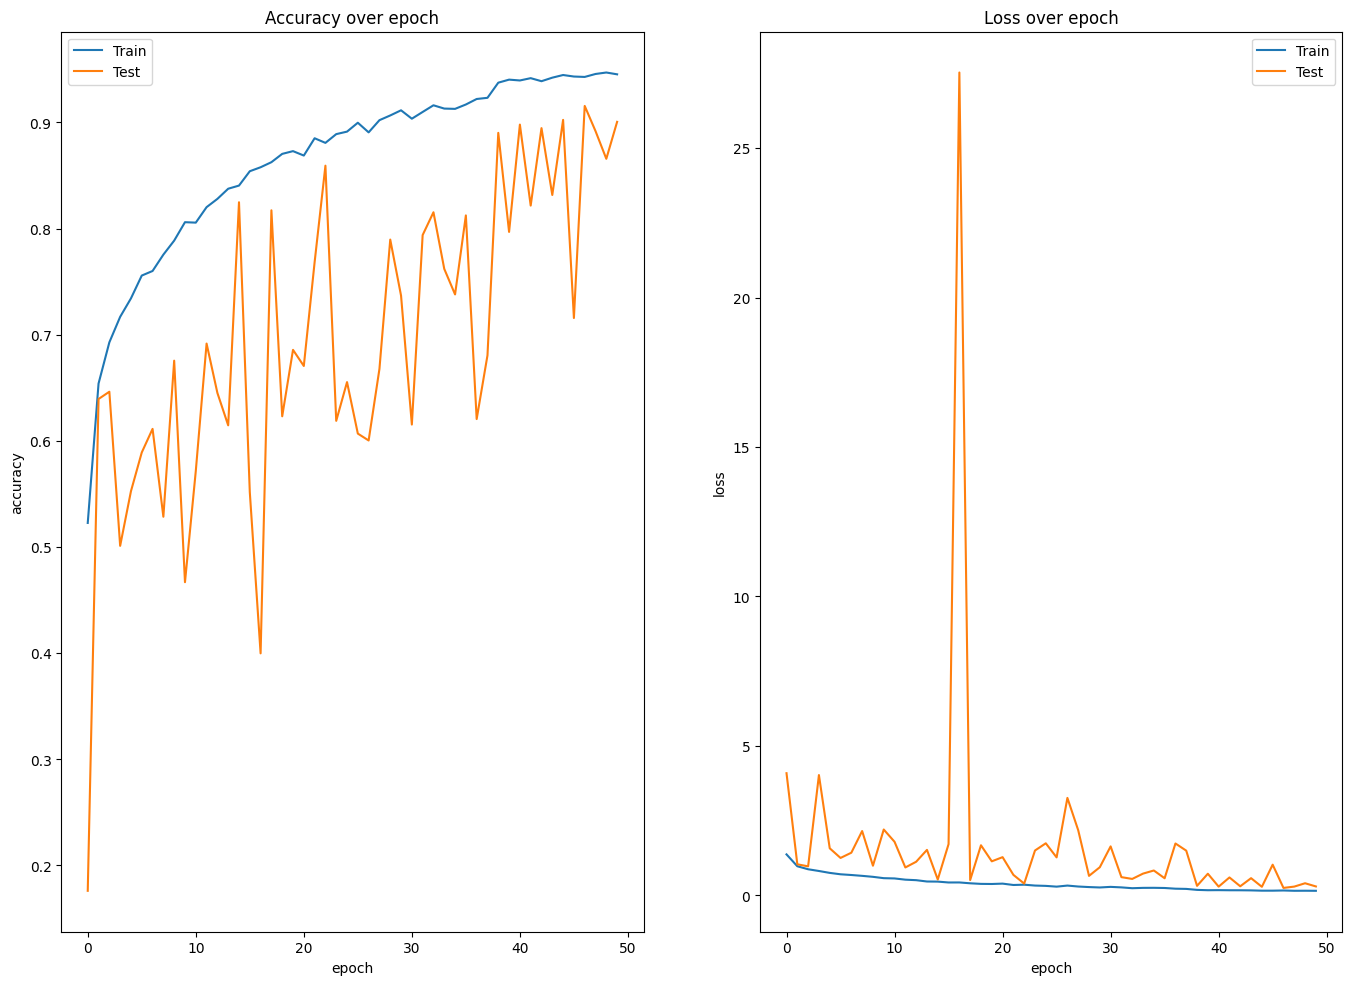

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")
plt.show()

In [18]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

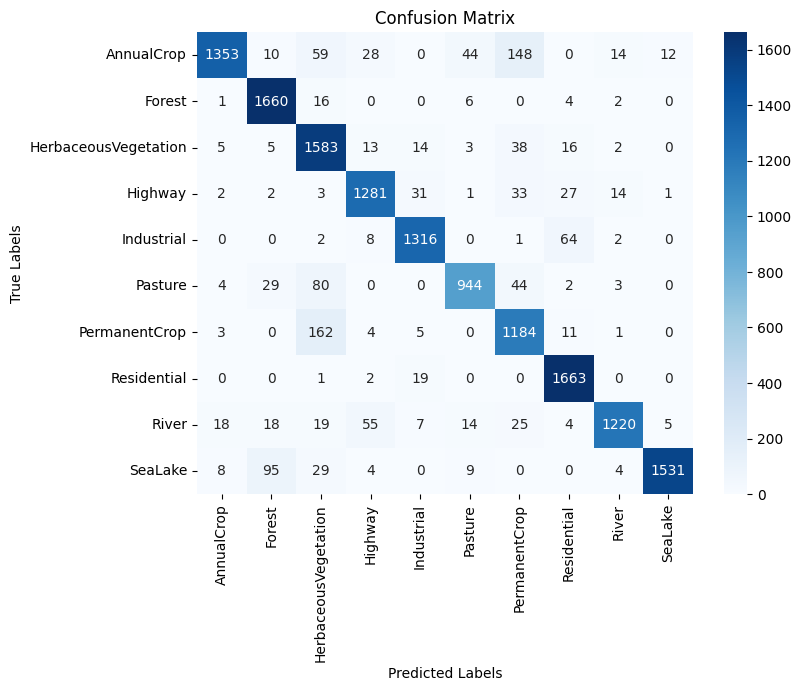

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(correct_labels, predicted_labels)
cm

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

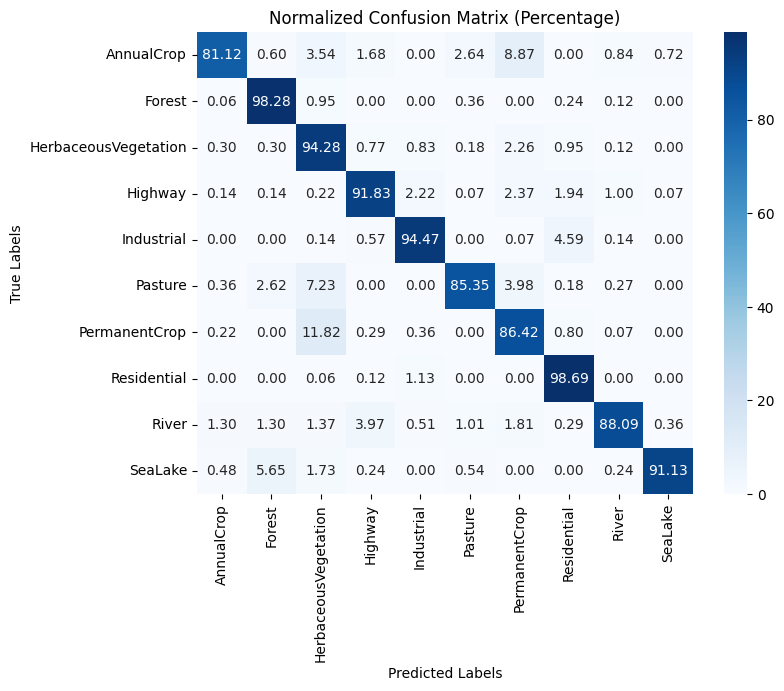

Number of correct predictions per class: [1353 1660 1583 1281 1316  944 1184 1663 1220 1531]
Total number of correct predictions: 13735
Number of false positives per class: [ 41 159 371 114  76  77 289 128  42  18]
Total number of false positives: 1315


In [20]:
# Compute the confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels)

# Normalize the confusion matrix by converting counts to percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Percentage)')
plt.show()

# Print number of correct predictions and false positives
# Diagonal elements represent the number of correct predictions
correct_predictions = np.diag(cm)
total_correct = correct_predictions.sum()

# False positives are the sum of predictions that are incorrectly classified as each class
false_positives = cm.sum(axis=0) - correct_predictions

# Total number of false positives across all classes
total_false_positives = false_positives.sum()

print(f"Number of correct predictions per class: {correct_predictions}")
print(f"Total number of correct predictions: {total_correct}")
print(f"Number of false positives per class: {false_positives}")
print(f"Total number of false positives: {total_false_positives}")

In [21]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')


Confusion matrix, without normalization
[[1353   10   59   28    0   44  148    0   14   12]
 [   1 1660   16    0    0    6    0    4    2    0]
 [   5    5 1583   13   14    3   38   16    2    0]
 [   2    2    3 1281   31    1   33   27   14    1]
 [   0    0    2    8 1316    0    1   64    2    0]
 [   4   29   80    0    0  944   44    2    3    0]
 [   3    0  162    4    5    0 1184   11    1    0]
 [   0    0    1    2   19    0    0 1663    0    0]
 [  18   18   19   55    7   14   25    4 1220    5]
 [   8   95   29    4    0    9    0    0    4 1531]]


In [23]:
from tensorflow.keras.models import load_model
#model = load_model(r"lulc_30_epoch.h5")

model.save('Training_Model200.h5')
model_path = r'C:\Users\abudh\Desktop\CropWatch\Training_model0908.h5'
model.save(model_path)

#model.save('lulc_30_epoch.h5')
#model.save('lulc_30_epoch.keras')

In [24]:
import os

# Check the number of images per class
class_counts = {}
for class_name in os.listdir(dataset_url):
    class_path = os.path.join(dataset_url, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print(class_counts)


{'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}


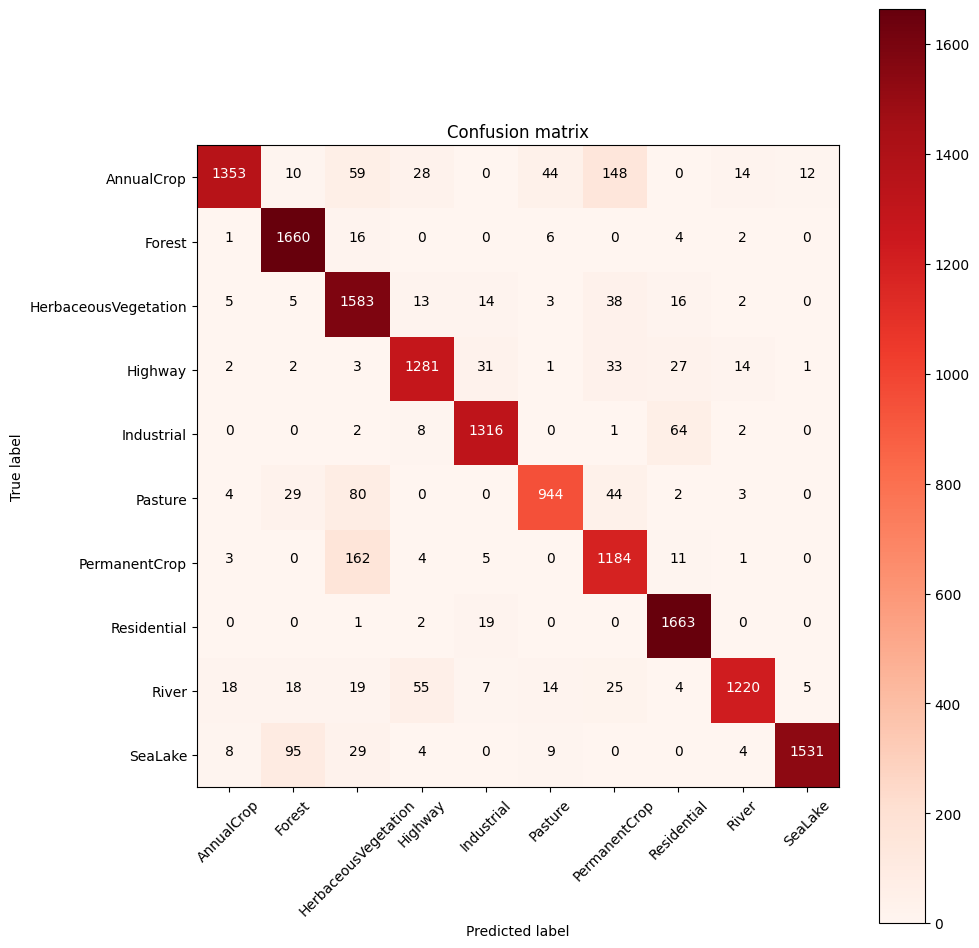

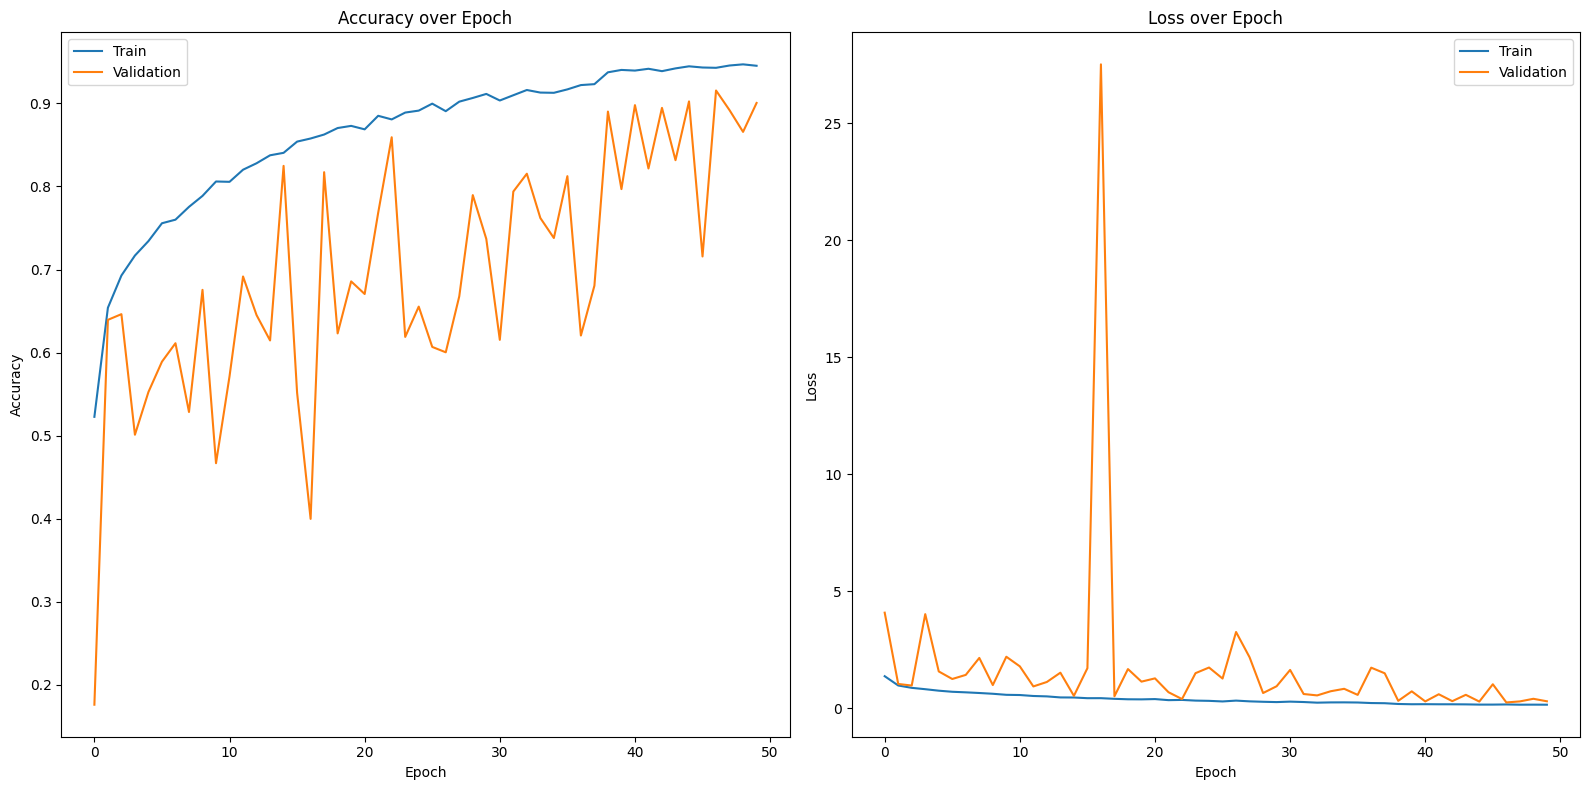

In [25]:
# Plot training & validation accuracy values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Accuracy Plot
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy over Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss over Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [26]:
# Manual calculation of Precision, Recall, and F1-Score
num_classes = len(class_names)
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1 = np.zeros(num_classes)

for i in range(num_classes):
    true_positive = cm[i, i]
    false_positive = cm[:, i].sum() - true_positive
    false_negative = cm[i, :].sum() - true_positive
    true_negative = cm.sum() - (true_positive + false_positive + false_negative)
    
    if true_positive + false_positive > 0:
        precision[i] = true_positive / (true_positive + false_positive)
    else:
        precision[i] = 0

    if true_positive + false_negative > 0:
        recall[i] = true_positive / (true_positive + false_negative)
    else:
        recall[i] = 0

    if precision[i] + recall[i] > 0:
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    else:
        f1[i] = 0

# Print precision, recall, and F1-score
print("Precision, Recall, and F1-Score:")
for i, class_name in enumerate(class_names):
    print(f"Class '{class_name}': Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}, F1-Score = {f1[i]:.2f}")

Precision, Recall, and F1-Score:
Class 'AnnualCrop': Precision = 0.97, Recall = 0.81, F1-Score = 0.88
Class 'Forest': Precision = 0.91, Recall = 0.98, F1-Score = 0.95
Class 'HerbaceousVegetation': Precision = 0.81, Recall = 0.94, F1-Score = 0.87
Class 'Highway': Precision = 0.92, Recall = 0.92, F1-Score = 0.92
Class 'Industrial': Precision = 0.95, Recall = 0.94, F1-Score = 0.95
Class 'Pasture': Precision = 0.92, Recall = 0.85, F1-Score = 0.89
Class 'PermanentCrop': Precision = 0.80, Recall = 0.86, F1-Score = 0.83
Class 'Residential': Precision = 0.93, Recall = 0.99, F1-Score = 0.96
Class 'River': Precision = 0.97, Recall = 0.88, F1-Score = 0.92
Class 'SeaLake': Precision = 0.99, Recall = 0.91, F1-Score = 0.95
